# Gesture Recognition

Create a deep neural network model that can correctly predict five hand gestures.

In [64]:
import os
import datetime
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [42]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [45]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [44]:
!unzip /content/gdrive/MyDrive/Assignment/PROJECT.zip

Archive:  /content/gdrive/MyDrive/Assignment/PROJECT.zip
replace Neural_Nets_Project_Starter_Code updated.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [46]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())
batch_size = 15

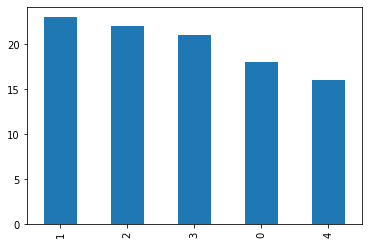

In [47]:
import pandas as pd
df = pd.read_csv('/content/Project_data/val.csv', sep=';', header=None)
df[2].value_counts().plot.bar()

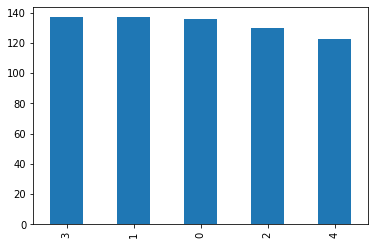

In [7]:
df = pd.read_csv('/content/Project_data/train.csv', sep=';', header=None)
df[2].value_counts().plot.bar()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [48]:
def image_batch_processor(t, source_path, img_idx, x, y, z, batch, batch_size):
    batch_data = np.zeros((batch_size, x, y, z, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        name, guster, label =  t[folder+(batch*batch_size)].strip().split(';')
        imgs = sorted(os.listdir(source_path+'/'+name)) # read all the images in the folder
        for idx, item in enumerate(img_idx): #  Iterate the frames/images of a folder to read them in
            image = Image.open(source_path+'/'+name+'/'+imgs[item]) # Read the image
            width, height = image.size
            left, right, top, bottom = 5, width-5, 5, height-5
            image = image.crop((left, top, right, bottom)) # crop the image.
            image = image.resize((y, z)) # Resize the image.
            image = np.asarray(image, dtype=np.float32) # convert image to numpy array.
            batch_data[folder,idx,:,:,0] = image[:, :, 0].T/255 #normalise and feed in the image
            batch_data[folder,idx,:,:,1] = image[:, :, 1].T/255
            batch_data[folder,idx,:,:,2] = image[:, :, 2].T/255
        batch_labels[folder, int(label)] = 1
    return batch_data, batch_labels


img_idx = (3, 6, 11, 13, 16, 20, 23, 26, 28)
# img_idx = (3, 6, 10, 13, 15, 17, 20, 23, 26, 28)
def generator(source_path, folder_list, batch_size):
    x, y, z = len(img_idx), 120, 160
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        rem_batch_size = len(folder_list)-num_batches*batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            yield image_batch_processor(t, source_path, img_idx, x, y, z, batch, batch_size) # yield the batch_data and the batch_labels
        if rem_batch_size:
            yield image_batch_processor(t, source_path, img_idx, x, y, z, num_batches, rem_batch_size)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [50]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)
gusters = {0: 'Left Swipe', 4: 'Thumbs Up', 3:'Thumbs Down', 1:'Right Swipe', 2:'Stop Gesture'}

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [49]:
train_data_gen = generator(train_path, train_doc, batch_size)
image_batch, label_batch = next(train_data_gen)
input_shape = image_batch[0].shape

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(19,25))
    for n in range(batch_size):
        ax = plt.subplot(batch_size, len(img_idx), n)
        plt.imshow(np.rot90(image_batch[n, i], 3))
        plt.axis('off')
        idx+=1
        
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(19,25))
    s = set()
    for n in range(25):
        ax = plt.subplot(5,18,n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')

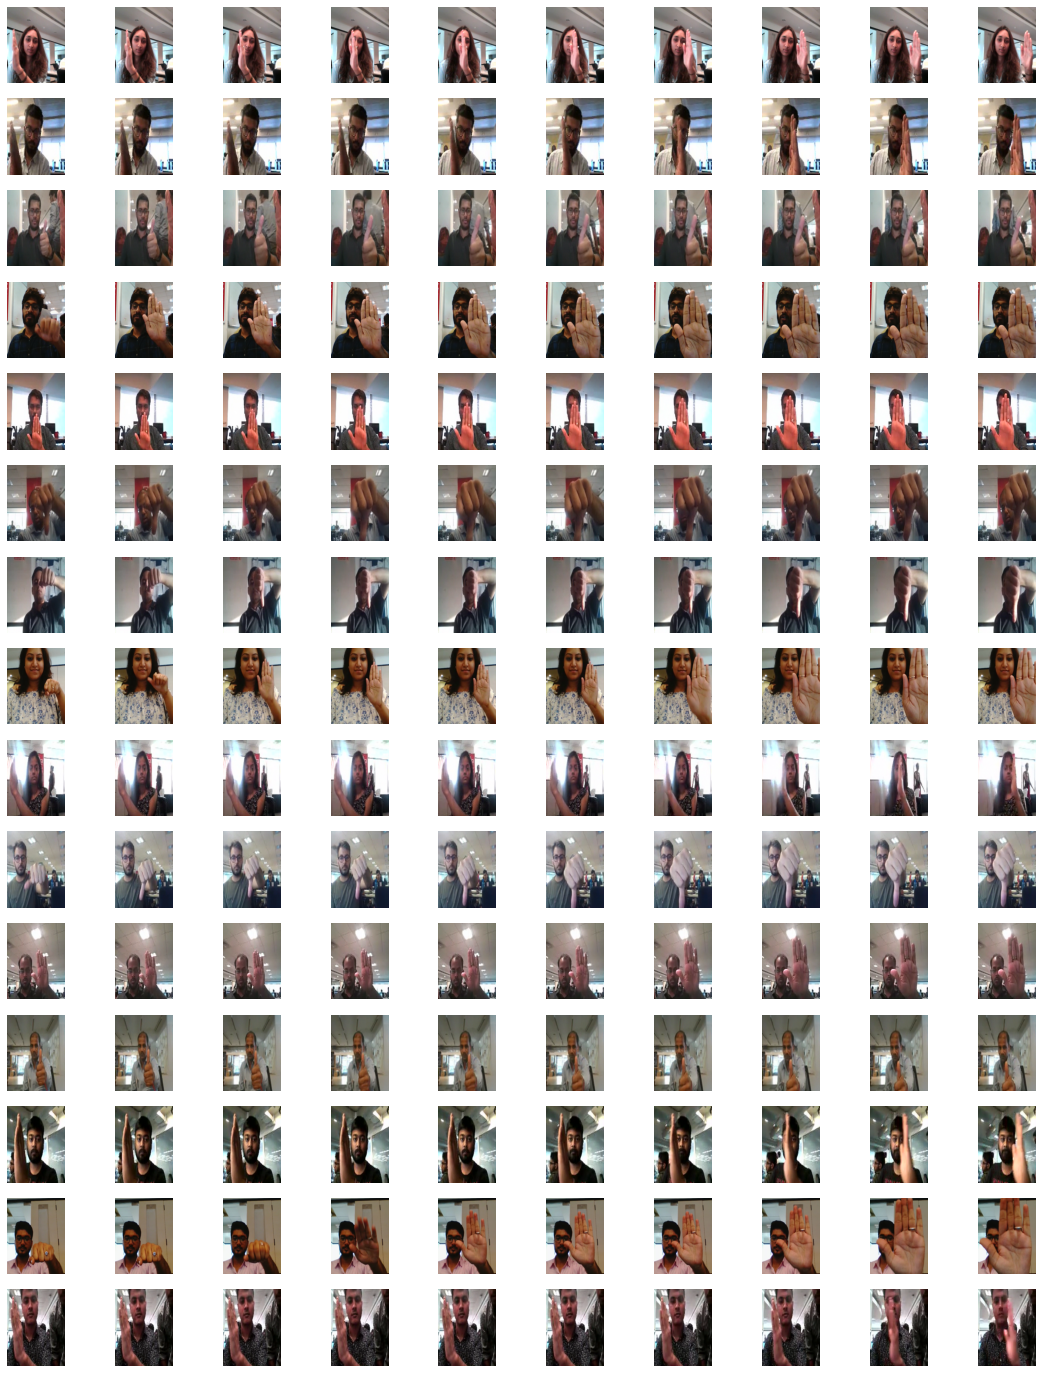

In [51]:
batch_size = 15
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(19,25))
    idx = 1
    for n in range(batch_size):
        for i in range(len(img_idx)):
            ax = plt.subplot(batch_size, len(img_idx), idx)
            plt.imshow(np.rot90(image_batch[n, i], 3))
            plt.axis('off')
            idx+=1

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1: Convolution 3D model without Batch Normalization

In [26]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()

# first conv layer
model.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=input_shape)) 
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

# second conv layer
model.add(Conv3D(32, kernel_size=(3, 3, 3), 
                 activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(len(gusters), activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [27]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 7, 118, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 3, 59, 79, 32)     0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 59, 79, 32)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 1, 57, 77, 32)     27680     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 1, 29, 39, 32)     0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 29, 39, 32)     0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36192)            

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [123]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [124]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

"""Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. 
  This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced."""
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,vpatience=5, min_lr=0.001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [126]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [51]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
45/45 [==============================] - 30s 660ms/step - loss: 2.1637 - categorical_accuracy: 0.1935 - val_loss: 1.6064 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2021-05-0115_35_32.666176/model-00001-1.78133-0.21267-1.60641-0.21000.h5
Epoch 2/30
45/45 [==============================] - 25s 571ms/step - loss: 1.5259 - categorical_accuracy: 0.2936 - val_loss: 1.3289 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2021-05-0115_35_32.666176/model-00002-1.48841-0.31976-1.32888-0.39000.h5
Epoch 3/30
45/45 [==============================] - 26s 581ms/step - loss: 1.2802 - categorical_accuracy: 0.4520 - val_loss: 1.0860 - val_categorical_accuracy: 0.5500

Epoch 00003: saving model to model_init_2021-05-0115_35_32.666176/model-00003-1.24125-0.49472-1.08598-0.55000.h5
Epoch 4/30
45/45 [==============================] - 26s 579ms/step - loss: 0.9710 - categorical_accuracy: 0.6230 - val_loss: 0.9789 - val_categorical_accurac

### Model 2: Convolution 3D model with Batch Normalization

In [142]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, ConvLSTM2D, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model2 = Sequential()

# first conv layer
model2.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=input_shape)) 
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization())

# second conv layer
model2.add(Conv3D(64, kernel_size=(3, 3, 3), 
                 activation='relu'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model2.add(BatchNormalization())

# flatten and put a fully connected layer
model2.add(Flatten())
model2.add(Dense(128, activation='relu')) # fully connected
model2.add(Dropout(0.55))

# softmax layer
model2.add(Dense(len(gusters), activation='softmax'))

model2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 7, 118, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 3, 59, 79, 32)     0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 59, 79, 32)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 1, 57, 77, 32)     27680     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 1, 29, 39, 32)     0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 29, 39, 32)     0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36192)            

In [137]:
model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
45/45 [==============================] - 25s 557ms/step - loss: 4.7752 - categorical_accuracy: 0.3248 - val_loss: 2.1073 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2021-05-0206_23_38.521390/model-00001-3.53105-0.36048-2.10733-0.30000.h5
Epoch 2/30
45/45 [==============================] - 24s 537ms/step - loss: 1.1530 - categorical_accuracy: 0.5947 - val_loss: 2.5841 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2021-05-0206_23_38.521390/model-00002-1.11592-0.60483-2.58408-0.39000.h5
Epoch 3/30
45/45 [==============================] - 24s 550ms/step - loss: 0.8181 - categorical_accuracy: 0.6627 - val_loss: 2.5859 - val_categorical_accuracy: 0.3600

Epoch 00003: saving model to model_init_2021-05-0206_23_38.521390/model-00003-0.82063-0.68175-2.58587-0.36000.h5
Epoch 4/30
45/45 [==============================] - 24s 544ms/step - loss: 0.5459 - categorical_accuracy: 0.7700 - val_loss: 2.7082 - val_categorical_accurac

### Model 3: Convolution 2D + GRU

In [143]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling2D, Conv2D, TimeDistributed, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model4 = Sequential()

# first conv+RNN layer
model4.add(TimeDistributed(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))) 
model4.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model4.add(BatchNormalization())
# model2.add(Dropout(0.25))

# second conv+RNN layer
model4.add(TimeDistributed(Conv2D(32, kernel_size=(3, 3), 
                 activation='relu')))
model4.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model4.add(BatchNormalization())
# model.add(Dropout(0.25))

# third conv+RNN layer
model4.add(TimeDistributed(Conv2D(16, kernel_size=(3, 3), 
                 activation='relu')))
model4.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model4.add(BatchNormalization())
# model.add(Dropout(0.25))

# flatten and put a fully connected layer
model4.add(TimeDistributed(Flatten()))
model4.add(GRU(128, activation='relu')) # fully connected
model4.add(Dropout(0.5))

# softmax layer
model4.add(Dense(len(gusters), activation='softmax'))
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 7, 118, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 3, 59, 79, 32)     0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 59, 79, 32)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 1, 57, 77, 32)     27680     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 1, 29, 39, 32)     0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 29, 39, 32)     0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36192)            

In [144]:
model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
45/45 [==============================] - 30s 583ms/step - loss: 1.8141 - categorical_accuracy: 0.4450 - val_loss: 2.2001 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2021-05-0206_23_38.521390/model-00001-1.56158-0.50075-2.20013-0.18000.h5
Epoch 2/30
45/45 [==============================] - 26s 579ms/step - loss: 0.7088 - categorical_accuracy: 0.7607 - val_loss: 2.6498 - val_categorical_accuracy: 0.2500

Epoch 00002: saving model to model_init_2021-05-0206_23_38.521390/model-00002-0.68660-0.75716-2.64985-0.25000.h5
Epoch 3/30
45/45 [==============================] - 26s 577ms/step - loss: 0.6158 - categorical_accuracy: 0.7888 - val_loss: 5.5325 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2021-05-0206_23_38.521390/model-00003-0.60049-0.79487-5.53250-0.20000.h5
Epoch 4/30
45/45 [==============================] - 26s 591ms/step - loss: 0.5000 - categorical_accuracy: 0.8241 - val_loss: 3.2356 - val_categorical_accurac

### Model 4: Convolution 3D + Convolution LSTM 2D

In [141]:
model3 = Sequential()

model3.add(Conv3D(32, kernel_size=(3, 3, 3),
                 activation='relu',
                 input_shape=input_shape)) 
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
# model3.add(ConvLSTM2D(16,kernel_size = (3, 3),
#                                        padding = 'same',
#                                        return_sequences = True,
#                                        input_shape=input_shape))
model3.add(ConvLSTM2D(16,kernel_size = (3, 3),
                                       padding = 'same',
                                       return_sequences = True))
model3.add(Conv3D(8, kernel_size=(1, 3, 3), padding='same', activation='relu'))
model3.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model3.add(BatchNormalization())

# flatten and put a fully connected layer
model3.add(Flatten())
model3.add(Dense(128, activation='relu')) # fully connected
model3.add(Dropout(0.5))

# softmax layer
model3.add(Dense(len(gusters), activation='softmax'))

model3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 7, 118, 158, 32)   2624      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 3, 59, 79, 32)     0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 59, 79, 32)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 1, 57, 77, 32)     27680     
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 1, 29, 39, 32)     0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 29, 39, 32)     0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36192)            

In [92]:
model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
45/45 [==============================] - 28s 581ms/step - loss: 2.1931 - categorical_accuracy: 0.3539 - val_loss: 1.6222 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2021-05-0206_23_38.521390/model-00001-1.75062-0.45098-1.62224-0.18000.h5
Epoch 2/30
45/45 [==============================] - 25s 565ms/step - loss: 1.0431 - categorical_accuracy: 0.6362 - val_loss: 1.5828 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-05-0206_23_38.521390/model-00002-0.96713-0.64857-1.58275-0.23000.h5
Epoch 3/30
45/45 [==============================] - 25s 554ms/step - loss: 0.7195 - categorical_accuracy: 0.7220 - val_loss: 1.7207 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init_2021-05-0206_23_38.521390/model-00003-0.65936-0.73756-1.72071-0.25000.h5
Epoch 4/30
45/45 [==============================] - 25s 561ms/step - loss: 0.4924 - categorical_accuracy: 0.8096 - val_loss: 1.2851 - val_categorical_accurac